# MPL deeplearning

In [8]:
from  datetime import datetime, timedelta
# import gc
import numpy as np, pandas as pd
from sklearn.ensemble import RandomForestRegressor
import time	
from sklearn.externals import joblib

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

In [9]:
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }
prices = pd.read_csv("../datasets/sell_prices.csv", dtype = PRICE_DTYPES)
for col, col_dtype in PRICE_DTYPES.items():
    if col_dtype == "category":
        prices[col] = prices[col].cat.codes.astype("int16")  # 类似于labelencoder，将store_id和item_id数字化表示
        prices[col] -= prices[col].min()  
# prices.head(1)

In [10]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
cal = pd.read_csv("../datasets/calendar.csv", dtype = CAL_DTYPES)
cal["date"] = pd.to_datetime(cal["date"])  #  转化为datetime类型
for col, col_dtype in CAL_DTYPES.items():
    if col_dtype == "category":
        cal[col] = cal[col].cat.codes.astype("int16")  # 将event_name_1/event_type_1/event_name_2/event_type_2weekday数字化表示
        cal[col] -= cal[col].min()  # NaN会转换为-1，该代表将NaN归为0，其他从1开始
# cal.head(1)

In [11]:
h = 28 
max_lags = 57
last_day = 1913  # 历史的最后一天
fday = datetime(2016,4, 25)  # 预测的第一天
fday
nrows_demo=None
# nrows_demo=10000

In [12]:
%time
first_day = 1750
numcols = [f"d_{day}" for day in range(first_day, last_day + 1)]  # 选取历史数据，从first_day到tr_last（包含这一天）d_1200,d_1201
catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
dtype = {numcol: "float32" for numcol in numcols}   # d_1200为float32

dtype.update({col: "category" for col in catcols if col != "id"})  # 除id外，都为category类型
dt = pd.read_csv("../datasets/sales_train_validation.csv", usecols = catcols + numcols, dtype = dtype,nrows=nrows_demo)  # 取catcols和numcols的列(只取了需要的历史天数销量数据)
dt

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10 µs


,id,item_id,dept_id,cat_id,store_id,state_id,d_1750,d_1751,d_1752,d_1753,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,2.0,...,1.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,...,2.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1.0,1.0,1.0,3.0,...,1.0,0.0,5.0,4.0,1.0,0.0,1.0,3.0,7.0,2.0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1.0,1.0,2.0,0.0,...,2.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1.0,0.0,1.0,2.0,...,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0.0,0.0,4.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,1.0,3.0


In [13]:
for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")  # 数字化
            dt[col] -= dt[col].min()
    
    
for day in range(last_day + 1, last_day + 28 +1):  # 遍历预测的每一天
    dt[f"d_{day}"] = np.nan  # 先填充为NaN

dt = pd.melt(dt,
              id_vars = catcols,
              value_vars = [col for col in dt.columns if col.startswith("d_")],
              var_name = "d",
              value_name = "sales")



In [14]:
dt = dt.merge(cal, on= "d", copy = False)
dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)

In [15]:
dt.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1750,0.0,2015-11-13,11541,...,11,2015,0,0,0,0,0.0,1.0,0.0,8.26
1,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_1750,0.0,2015-11-13,11541,...,11,2015,0,0,0,0,0.0,1.0,0.0,3.97
2,HOBBIES_1_003_CA_1_validation,2,0,0,0,0,d_1750,0.0,2015-11-13,11541,...,11,2015,0,0,0,0,0.0,1.0,0.0,2.97
3,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_1750,1.0,2015-11-13,11541,...,11,2015,0,0,0,0,0.0,1.0,0.0,4.64
4,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,d_1750,1.0,2015-11-13,11541,...,11,2015,0,0,0,0,0.0,1.0,0.0,2.88


In [16]:
# # first_day为预测的第一天

# def create_dt(first_day = 1200):
#     prices = pd.read_csv("sell_prices.csv", dtype = PRICE_DTYPES)
#     for col, col_dtype in PRICE_DTYPES.items():
#         if col_dtype == "category":
#             prices[col] = prices[col].cat.codes.astype("int16")  # 类似于labelencoder，将store_id和item_id数字化表示
#             prices[col] -= prices[col].min()  
            
#     cal = pd.read_csv("calendar.csv", dtype = CAL_DTYPES)
#     cal["date"] = pd.to_datetime(cal["date"])  #  转化为datetime类型
#     for col, col_dtype in CAL_DTYPES.items():
#         if col_dtype == "category":
#             cal[col] = cal[col].cat.codes.astype("int16")  # 将event_name_1/event_type_1/event_name_2/event_type_2weekday数字化表示
#             cal[col] -= cal[col].min()  # NaN会转换为-1，该代表将NaN归为0，其他从1开始
    
#     # 处理train_validation文件
#     numcols = [f"d_{day}" for day in range(first_day, last_day + 1)]  # 选取历史数据，从first_day到tr_last（包含这一天）d_1200,d_1201
#     catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
#     dtype = {numcol: "float32" for numcol in numcols}   # d_1200为float32
    
#     dtype.update({col: "category" for col in catcols if col != "id"})  # 除id外，都为category类型
#     dt = pd.read_csv("sales_train_validation.csv", usecols = catcols + numcols, dtype = dtype,nrows=10000)  # 取catcols和numcols的列(只取了需要的历史天数销量数据)
    
#     for col in catcols:
#         if col != "id":
#             dt[col] = dt[col].cat.codes.astype("int16")  # 数字化
#             dt[col] -= dt[col].min()
    
    
#     for day in range(last_day + 1, last_day + 28 +1):  # 遍历预测的每一天
#         dt[f"d_{day}"] = np.nan  # 先填充为NaN
    
#     dt = pd.melt(dt,
#                   id_vars = catcols,
#                   value_vars = [col for col in dt.columns if col.startswith("d_")],
#                   var_name = "d",
#                   value_name = "sales")
    
#     dt = dt.merge(cal, on= "d", copy = False)
#     dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
#     return dt

In [17]:
# FIRST_DAY = 1750

In [18]:
dt["d"]=dt["d"].apply(lambda x: int(x.split("_")[1])) # d_1 to 1


In [19]:
df = dt.copy()

In [20]:
def create_fea(dt):
    lags = [7, 28]
#     lags = [7]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):  # [(7, lag_7), (28, lag_28)]
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)  # 新增两列，同一商品前7天的单价和前28天的价格

    wins = [7, 28]
#     wins = [7]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()) 

            # log=7，wins=28表示一个商品当前的参考价为：从当前时间7天前（如1.8号的七天前是1.1号）开始一共向上取28天，求这些天的均值
    
    date_features = {
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",

    }
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [21]:
create_fea(df)

In [22]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,...,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,1750,0.0,2015-11-13,11541,...,8.26,NaN,NaN,NaN,NaN,NaN,NaN,46,4,13
1,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,1750,0.0,2015-11-13,11541,...,3.97,NaN,NaN,NaN,NaN,NaN,NaN,46,4,13
2,HOBBIES_1_003_CA_1_validation,2,0,0,0,0,1750,0.0,2015-11-13,11541,...,2.97,NaN,NaN,NaN,NaN,NaN,NaN,46,4,13
3,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,1750,1.0,2015-11-13,11541,...,4.64,NaN,NaN,NaN,NaN,NaN,NaN,46,4,13
4,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,1750,1.0,2015-11-13,11541,...,2.88,NaN,NaN,NaN,NaN,NaN,NaN,46,4,13


In [23]:
df.dropna(inplace = True)
df.shape

(3321687, 31)

In [24]:
df.columns

Index(['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_7', 'lag_28',
       'rmean_7_7', 'rmean_28_7', 'rmean_7_28', 'rmean_28_28', 'week',
       'quarter', 'mday'],
      dtype='object')

In [25]:
# cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_type_1", "event_type_2"]
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] 
# useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday", 'event_name_1', 'event_name_2']
# useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
useless_cols = ["id", "date", "sales", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
print(train_cols)
X_train = df[train_cols]
y_train = df["sales"]

Index(['item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'd', 'wday',
       'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_7',
       'lag_28', 'rmean_7_7', 'rmean_28_7', 'rmean_7_28', 'rmean_28_28',
       'week', 'quarter', 'mday'],
      dtype='object')


In [26]:
train_cols

Index(['item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'd', 'wday',
       'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_7',
       'lag_28', 'rmean_7_7', 'rmean_28_7', 'rmean_7_28', 'rmean_28_28',
       'week', 'quarter', 'mday'],
      dtype='object')

In [27]:
X_train.head()

,item_id,dept_id,store_id,cat_id,state_id,d,wday,month,year,event_name_1,...,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
1523279,0,0,0,0,0,1805,6,1,2016,20,...,8.26,1.0,0.0,0.857143,0.571429,0.750000,0.571429,1,1,7
1523280,0,0,0,0,0,1806,7,1,2016,0,...,8.26,0.0,0.0,0.857143,0.571429,0.750000,0.571429,1,1,8
1523286,1,0,0,0,0,1805,6,1,2016,20,...,3.97,0.0,1.0,0.142857,0.714286,0.964286,0.428571,1,1,7
1523287,1,0,0,0,0,1806,7,1,2016,0,...,3.97,0.0,0.0,0.142857,0.714286,0.964286,0.428571,1,1,8
1523293,2,0,0,0,0,1805,6,1,2016,20,...,2.97,1.0,1.0,1.142857,1.000000,1.535714,1.000000,1,1,7


In [28]:
X_train.shape

(3321687, 26)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                864       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
________________________________________________

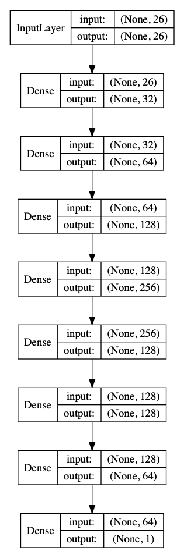

In [29]:
# from sklearn.neighbors import KNeighborsRegressor
# model_knn = KNeighborsRegressor(3)
# model_knn.fit(X_train, y_train)


ann_model = Sequential()

ann_model.add(Dense(
        units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train.shape[1]))

ann_model.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))

ann_model.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))

ann_model.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu'))

ann_model.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))

ann_model.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))


ann_model.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))


ann_model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'softmax'))

ann_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
ann_model.summary()

image_name = 'plusarStars_ann_model.png'
plot_model(ann_model,to_file=image_name,show_shapes=True,show_layer_names=False,rankdir='TB')
plt.figure(figsize=(10,10))
img = plt.imread(image_name)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
ann_model.fit(X_train, y_train, batch_size=200, epochs=20)

hist = ann_model.fit(X_train, y_train,
                    batch_size=200,
                    epochs=5,
                    verbose=1)

# score = ann_model.evaluate(X_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
3321687/3321687 [==============================] - 100s 30us/step - loss: -5.7663 - accuracy: 0.1823
Epoch 2/20
3321687/3321687 [==============================] - 97s 29us/step - loss: -5.7663 - accuracy: 0.1823
Epoch 3/20
3321687/3321687 [==============================] - 98s 30us/step - loss: -5.7663 - accuracy: 0.1823
Epoch 4/20
3321687/3321687 [==============================] - 95s 29us/step - loss: -5.7663 - accuracy: 0.1823
Epoch 5/20
3321687/3321687 [==============================] - 91s 27us/step - loss: -5.7663 - accuracy: 0.1823
Epoch 6/20
3321687/3321687 [==============================] - 97s 29us/step - loss: -5.7663 - accuracy: 0.1823
Epoch 7/20
3321687/3321687 [==============================] - 97s 29us/step - loss: -5.7663 - accuracy: 0.1823
Epoch 8/20
3321687/3321687 [==============================] - 98s 29us/step - loss: -5.7663 - accuracy: 0.1823
Epoch 9/20
1487600/3321687 [============>.................] - E

In [ ]:
alphas = [1.035, 1.03, 1.025]
# alphas = [1.035]
weights = [1 / len(alphas)] * len(alphas)  # 权重，当前权重值一样
print(weights)

In [ ]:
# alphas：利用lgb预测出模型后，乘以alphas才为最终的预测值
# weight：由于有三个alphas，这三个alphas得出的结果各赋予一定的权重

sub = 0.
cols = [f"F{i}" for i in range(1,29)]

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):  # [(1.035, 0.333), (1.03, 0.333), (1.025, 0.333)]
    # te是所有的数据，tst是部分数据
#     te = create_dt(False)  # is_train = False  原始数据
    te = dt
#     print(de)
#     te = create_dt(first_day = FIRST_DAY)# todo
#     te["d"]=te["d"].apply(lambda x: int(x.split("_")[1])) # d_1 to 1

#     cols = [f"F{i}" for i in range(1,29)]

    for tdelta in range(0, 28):
        day = fday + timedelta(days=tdelta)  # 预测的具体哪一天，比如第1914那天的日期
#         print(tdelta)
        print(icount, day)
#         print((te.date >= day - timedelta(days=max_lags)) & (te.date <= day))

        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()  
        create_fea(tst)
        tst = tst.loc[tst.date == day , train_cols]  # 需要预测的数据
#         print(tst)
        te.loc[te.date == day, "sales"] = alpha * ann_model.predict(tst) # magic multiplier by kyakovlev
#         print(te)
    

#     te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()  # 取出预测的数据  # todo 此处 copy 意义？
    te_sub = te.loc[te.date >= fday, ["id", "sales"]]  # 取出预测的数据  # todo 此处 copy 意义？
#     te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h), 
#                                                                           "id"].str.replace("validation$", "evaluation")
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]  # [F1,F2,F3,...F28]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()  # 转变成submission的形式（只是index只有每种商品的预测值，没有分位数和汇总的一些）
    te_sub.fillna(0., inplace = True) 
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
#     te_sub.to_csv(f"submission_rf_{icount}.csv",index=False)
    if icount == 0 :
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    print(icount, alpha, weight)



In [ ]:
print(sub.shape)
print(sub.columns)
sub.head()

In [ ]:

sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
# sub.to_csv("submission_rf.csv",index=False)

In [ ]:
sub

In [ ]:
sub.to_csv("submission_mpl.csv",index=False)